In [1]:
from glob import glob
from src.systems.humanoid.system import HumanoidSystem
from src.flow_matching.humanoid.latent_conditional.flow_matcher import HumanoidLatentConditionalFlowMatcher
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import torch

data_dir = "/common/users/shared/pracsys/genMoPlan/data_trajectories/humanoid_get_up_slow_stable_split"
roa_file = "/common/users/shared/pracsys/genMoPlan/data_trajectories/humanoid_get_up_slow_stable_split/roa_labels.txt"
bounds_file = "/common/users/dm1487/arcmg_datasets/humanoid_get_up/humanoid_data_bounds.pkl"


system = HumanoidSystem(bounds_file=bounds_file, use_dynamic_bounds=True, head_height_threshold=1.4, torso_z_threshold=0.9, speed_threshold=0.2)

 

ckpt_path = "/common/home/dm1487/robotics_research/tripods/olympics-classifier/outputs/humanoid_slow_reach_gaussian001_bs256/2025-11-03_07-40-46"
flow_matcher = HumanoidLatentConditionalFlowMatcher.load_from_checkpoint(ckpt_path, device="cuda:0")

✅ Loaded Humanoid bounds from: /common/users/dm1487/arcmg_datasets/humanoid_get_up/humanoid_data_bounds.pkl
📊 Per-Dimension Normalization Limits:

   Euclidean Block 1 (dims 0-33):
     [ 0]: ±  0.859
     [ 1]: ±  1.375
     [ 2]: ±  0.725
     [ 3]: ±  0.526
     [ 4]: ±  0.633
     ... (29 more dimensions)

   Sphere (dims 34-36): NO NORMALIZATION (unit norm)

   Euclidean Block 2 (dims 37-66):
     [37]: ±  1.914
     [38]: ±  1.916
     [39]: ±  3.328
     [40]: ±  2.790
     [41]: ±  2.940
     ... (25 more dimensions)

Loaded Humanoid bounds from: /common/users/dm1487/arcmg_datasets/humanoid_get_up/humanoid_data_bounds.pkl
📁 Folder provided: /common/home/dm1487/robotics_research/tripods/olympics-classifier/outputs/humanoid_slow_reach_gaussian001_bs256/2025-11-03_07-40-46
🔍 Searching for checkpoint in folder...
   ✓ Found best checkpoint (val_loss=0.0002)
   📄 Using: epoch105-val_loss0.0002.ckpt
🤖 Loading Humanoid LCFM checkpoint: /common/home/dm1487/robotics_research/tripods/oly

In [ ]:

labels = {}

main_dir = "/common/users/shared/pracsys/genMoPlan/data_trajectories/humanoid_get_up_slow"
with open(main_dir + "/shuffled_indices.txt", "r") as f:
    for line in tqdm(f.readlines()):
        data = np.loadtxt(main_dir + "/trajectories/" + line.strip(), delimiter=",")
        ctr = 0
        for i in range(data.shape[0]-5, data.shape[0]):
            if system.is_in_attractor(data[i:i+1]).item():
                ctr  += 1
        if ctr == 5:
            labels[line.strip()] = 1
        else:
            labels[line.strip()] = 0

100%|██████████| 15000/15000 [03:13<00:00, 77.58it/s]


In [63]:
labels

{'sequence_2257.txt': 0,
 'sequence_4047.txt': 1,
 'sequence_5396.txt': 1,
 'sequence_6363.txt': 1,
 'sequence_11414.txt': 0,
 'sequence_6237.txt': 0,
 'sequence_1644.txt': 1,
 'sequence_13252.txt': 1,
 'sequence_11053.txt': 0,
 'sequence_12819.txt': 0,
 'sequence_1532.txt': 0,
 'sequence_484.txt': 0,
 'sequence_3247.txt': 0,
 'sequence_11366.txt': 1,
 'sequence_12986.txt': 0,
 'sequence_12864.txt': 0,
 'sequence_6232.txt': 1,
 'sequence_480.txt': 0,
 'sequence_464.txt': 0,
 'sequence_3384.txt': 1,
 'sequence_5681.txt': 1,
 'sequence_4280.txt': 1,
 'sequence_10942.txt': 0,
 'sequence_8784.txt': 0,
 'sequence_5489.txt': 0,
 'sequence_11271.txt': 1,
 'sequence_11150.txt': 0,
 'sequence_10531.txt': 0,
 'sequence_4899.txt': 1,
 'sequence_6468.txt': 0,
 'sequence_11595.txt': 0,
 'sequence_11389.txt': 0,
 'sequence_14149.txt': 1,
 'sequence_4309.txt': 0,
 'sequence_11760.txt': 0,
 'sequence_1416.txt': 0,
 'sequence_5720.txt': 1,
 'sequence_5630.txt': 1,
 'sequence_3510.txt': 0,
 'sequence_23

In [66]:
start_states = []
final_states = []

split_labels = []
with open(data_dir + "/shuffled_indices.txt", "r") as f:
    for line in tqdm(f.readlines()):
        data = np.loadtxt(data_dir + "/split_trajectories/" + line.strip(), delimiter=",")
        if len(data.shape) > 1:
            start_states.append(data[0, :])
            final_states.append(data[-1, :])
            # print(line.strip().split("_part")[0]+ ".txt", labels[line.strip().split("_part")[0] + ".txt"])
            split_labels.append(labels[line.strip().split("_part")[0] + ".txt"])
            
split_labels = np.array(split_labels)


100%|██████████| 41435/41435 [03:23<00:00, 203.80it/s]


In [73]:
np.mean(split_labels), np.mean(np.array([i for i in labels.values()]))

(0.6607604103802052, 0.38233333333333336)

In [2]:
roa_data = np.loadtxt(roa_file, delimiter=",")
inp, labels = roa_data[:, :67], roa_data[:, 67]
inp = torch.from_numpy(inp).float().to("cuda:0")
labels = torch.from_numpy(labels).long().to("cuda:0")
np.mean(roa_data[:, 67] == 1)


0.3831333333333333

In [3]:
# from tqdm import tqdm
# samples = 20
# repeats = 1

# tp = 0
# tn = 0
# fp = 0
# fn = 0

# # idx = 2049
# for idx in tqdm(range(5, len(roa_data))):
#     all_head_heights = []
#     for _ in range(samples):
#         model_input = inp[idx:idx+1, :].clone()
#         head_height = []
#         for i in range(repeats):
#             pred = flow_matcher.predict_endpoint(model_input)
#             head_height.append(pred[:, 21].item())
#             model_input = pred.clone()
#         all_head_heights.append(head_height)
#     is_success = (sum(np.array(all_head_heights) > 1.3)/samples) > 0.5
#     # print(sum(np.array(all_head_heights) > 1.3)/samples, is_success, labels[idx])
#     if labels[idx] == 1 and is_success:
#         tp += 1
#     elif labels[idx] == 0 and is_success:
#         fp += 1
#     elif labels[idx] == 1 and not is_success:
#         fn += 1
#     elif labels[idx] == 0 and not is_success:
#         tn += 1
        
#     if idx == 50:
#         break

In [ ]:
from tqdm import tqdm

samples = 10
repeats = 1
batch_size = 2048  # You can tune this depending on memory
success_threshold = 0.6
failure_threshold = 0.4
tp = 0
tn = 0
fp = 0
fn = 0

sep_count = 0

start_idx = 0
stop_idx = len(roa_data)

is_success = np.zeros((len(roa_data), samples, repeats))
for batch_start in tqdm(range(start_idx, stop_idx, batch_size)):
    batch_end = min(batch_start + batch_size, stop_idx)
    batch_inp = inp[batch_start:batch_end, :]

    # Will be (batch_size, samples, repeats)
    for sample_idx in range(samples):
        model_input = batch_inp.clone()
        for repeat_idx in range(repeats):
            pred = flow_matcher.predict_endpoint(model_input)
            # pred shape: (batch_size, d)
            is_success[batch_start:batch_end, sample_idx, repeat_idx] = system.is_in_attractor(pred).cpu().numpy()
            model_input = pred.clone()
is_success_mean = is_success.mean(axis=(1,2))
is_success = (is_success_mean > success_threshold)
is_failure = (is_success_mean < failure_threshold) 
    # # Success logic: check along [samples, repeats] for each data point in batch
    # # We'll take the mean across all samples and repeats for head height > 1.3
    
    # mean_success = (all_head_heights > 1.3).mean(axis=(1,2))
    # is_success = mean_success > success_threshold  # shape: (batch_size,)
    
    # is_failure = mean_success < failure_threshold  # shape: (batch_size,)
    
    # sep_count += np.sum((mean_success <= success_threshold) & (mean_success >= failure_threshold))

    # batch_labels = labels[batch_start:batch_end].cpu().numpy()  # shape: (batch_size,)

    # tp += np.sum((batch_labels == 1) & (is_success))
    # fp += np.sum((batch_labels == 0) & (is_success))
    # fn += np.sum((batch_labels == 1) & (is_failure))c x   
    # tn += np.sum((batch_labels == 0) & (is_failure))

100%|██████████| 8/8 [00:16<00:00,  2.09s/it]


In [5]:
np.mean(is_success == is_failure), np.mean(is_success), np.mean(is_failure)

(0.11513333333333334, 0.8073333333333333, 0.07753333333333333)

In [11]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
specificity = tn / (tn + fp)
sep_perc = sep_count/len(roa_data)
print(f"Precision: {precision}, Recall: {recall}, F1: {f1}, Specificity: {specificity}, Sep: {sep_perc}")

# confusion matrix
conf_mat = np.zeros((2, 2))
conf_mat[0, 0] = tp
conf_mat[0, 1] = fp
conf_mat[1, 0] = fn
conf_mat[1, 1] = tn


Precision: 0.4686931473620376, Recall: 0.9513771349438375, F1: 0.6280026408003657, Specificity: 0.07202436118098769, Sep: 0.0632


In [6]:
conf_mat

array([[6183., 7009.],
       [ 316.,  544.]])

In [145]:
success_count = 0
failure_count = 0
success_lengths = []
failure_lengths = []
from tqdm import tqdm

for file in tqdm(glob(os.path.join(data_dir, "trajectories/*.txt"))):
    data = np.loadtxt(file, delimiter=",")
    success = False
    if system.is_in_attractor(data[-1:]).item():
        success_count += 1
        success_lengths.append(data.shape[0])
    else:
        failure_count += 1
        failure_lengths.append(data.shape[0])
        
    if (success_count + failure_count) % 1000 == 0:
        print(f"Success count: {success_count}")
        print(f"Failure count: {failure_count}")
        print(f"Success rate: {success_count / (success_count + failure_count)}")
        print(f"Failure rate: {failure_count / (success_count + failure_count)}")
        print(f"Success lengths: {np.median(success_lengths)}")
        print(f"Failure lengths: {np.median(failure_lengths)}")

  7%|▋         | 1012/15000 [00:07<01:47, 130.12it/s]

Success count: 403
Failure count: 597
Success rate: 0.403
Failure rate: 0.597
Success lengths: 446.0
Failure lengths: 436.0


 13%|█▎        | 2012/15000 [00:15<01:39, 130.12it/s]

Success count: 784
Failure count: 1216
Success rate: 0.392
Failure rate: 0.608
Success lengths: 446.0
Failure lengths: 438.5


 20%|██        | 3017/15000 [00:23<01:33, 127.49it/s]

Success count: 1166
Failure count: 1834
Success rate: 0.38866666666666666
Failure rate: 0.6113333333333333
Success lengths: 446.0
Failure lengths: 441.0


 27%|██▋       | 4014/15000 [00:31<01:24, 130.44it/s]

Success count: 1546
Failure count: 2454
Success rate: 0.3865
Failure rate: 0.6135
Success lengths: 446.0
Failure lengths: 436.0


 33%|███▎      | 5023/15000 [00:39<01:16, 130.99it/s]

Success count: 1922
Failure count: 3078
Success rate: 0.3844
Failure rate: 0.6156
Success lengths: 441.0
Failure lengths: 436.0


 40%|████      | 6014/15000 [00:46<01:09, 130.14it/s]

Success count: 2327
Failure count: 3673
Success rate: 0.3878333333333333
Failure rate: 0.6121666666666666
Success lengths: 441.0
Failure lengths: 436.0


 47%|████▋     | 7012/15000 [00:54<01:00, 131.99it/s]

Success count: 2695
Failure count: 4305
Success rate: 0.385
Failure rate: 0.615
Success lengths: 441.0
Failure lengths: 441.0


 53%|█████▎    | 8019/15000 [01:02<00:52, 132.82it/s]

Success count: 3075
Failure count: 4925
Success rate: 0.384375
Failure rate: 0.615625
Success lengths: 441.0
Failure lengths: 441.0


 60%|██████    | 9025/15000 [01:10<00:46, 127.77it/s]

Success count: 3438
Failure count: 5562
Success rate: 0.382
Failure rate: 0.618
Success lengths: 441.0
Failure lengths: 436.0


 67%|██████▋   | 10017/15000 [01:17<00:38, 128.60it/s]

Success count: 3807
Failure count: 6193
Success rate: 0.3807
Failure rate: 0.6193
Success lengths: 441.0
Failure lengths: 436.0


 74%|███████▎  | 11026/15000 [01:25<00:30, 131.35it/s]

Success count: 4196
Failure count: 6804
Success rate: 0.38145454545454544
Failure rate: 0.6185454545454545
Success lengths: 441.0
Failure lengths: 436.0


 80%|████████  | 12014/15000 [01:33<00:22, 132.48it/s]

Success count: 4597
Failure count: 7403
Success rate: 0.38308333333333333
Failure rate: 0.6169166666666667
Success lengths: 441.0
Failure lengths: 436.0


 87%|████████▋ | 13019/15000 [01:41<00:15, 128.00it/s]

Success count: 5007
Failure count: 7993
Success rate: 0.3851538461538462
Failure rate: 0.6148461538461538
Success lengths: 441.0
Failure lengths: 436.0


 93%|█████████▎| 14023/15000 [01:48<00:07, 130.99it/s]

Success count: 5388
Failure count: 8612
Success rate: 0.38485714285714284
Failure rate: 0.6151428571428571
Success lengths: 441.0
Failure lengths: 436.0


100%|██████████| 15000/15000 [01:56<00:00, 128.74it/s]

Success count: 5747
Failure count: 9253
Success rate: 0.3831333333333333
Failure rate: 0.6168666666666667
Success lengths: 441.0
Failure lengths: 436.0


In [147]:

print(f"Success count: {success_count}")
print(f"Failure count: {failure_count}")
print(f"Success rate: {success_count / (success_count + failure_count)}")
print(f"Failure rate: {failure_count / (success_count + failure_count)}")

Success count: 5747
Failure count: 9253
Success rate: 0.3831333333333333
Failure rate: 0.6168666666666667


In [30]:
print(f"Success lengths: {np.median(success_lengths)}")
print(f"Failure lengths: {np.median(failure_lengths)}")

Success lengths: 192.0
Failure lengths: 441.0


In [31]:
split_data_dir = "/common/users/dm1487/arcmg_datasets/humanoid_get_up_slow_stable_split/split_trajectories"
error_files = []
d = {
    's2s':[],
    's2f':[],
    'f2s':[],
    'f2f':[]
}

for file in tqdm(glob(os.path.join(split_data_dir, "*.txt"))):
    data = np.loadtxt(file, delimiter=",")
    
    try:
        first = system.is_in_attractor(data[:1]).item()
        last = system.is_in_attractor(data[-1:]).item()
        
        if first and last:
            d['s2s'].append(file)
        elif first and not last:
            d['s2f'].append(file)
        elif not first and last:
            d['f2s'].append(file)
        else:
            d['f2f'].append(file)
    except Exception as e:
        error_files.append(file)
    


100%|██████████| 41435/41435 [02:17<00:00, 302.08it/s]


In [32]:
total = sum(len(d[key]) for key in ['s2s', 's2f', 'f2s', 'f2f'])
ratios = {
    's2s': len(d['s2s']) / total,
    's2f': len(d['s2f']) / total,
    'f2s': len(d['f2s']) / total,
    'f2f': len(d['f2f']) / total,
}
print("Trajectory Class Distribution:")
for key, desc in zip[tuple[str, str]](['s2s', 's2f', 'f2s', 'f2f'],
                     ['succcess→success', 'success→fail', 'fail→success', 'fail→fail']):
    print(f"  {desc:10s}: {len(d[key]):5d} ({ratios[key]*100:6.2f}%)")
print(f"\nTotal trajectories: {total}")


Trajectory Class Distribution:


TypeError: 'type' object is not subscriptable

In [27]:
len(d['f2s']) - (len(d['s2f']) + len(d['s2s']))

4

In [29]:
len(error_files)

10

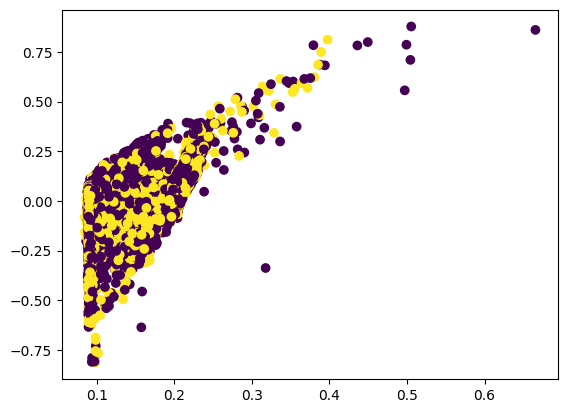

In [ ]:
plt.scatter(roa_data[:, 21], roa_data[:, 36], c=labels.cpu().numpy())

array([0.169385, 0.090364, 0.09009 , ..., 0.091246, 0.176324, 0.091955])

In [ ]:
# labels = []

# for state in final_states:
#     labels.append(system.is_in_attractor(state))
# labels = np.array(labels)


TypeError: 'NoneType' object is not callable

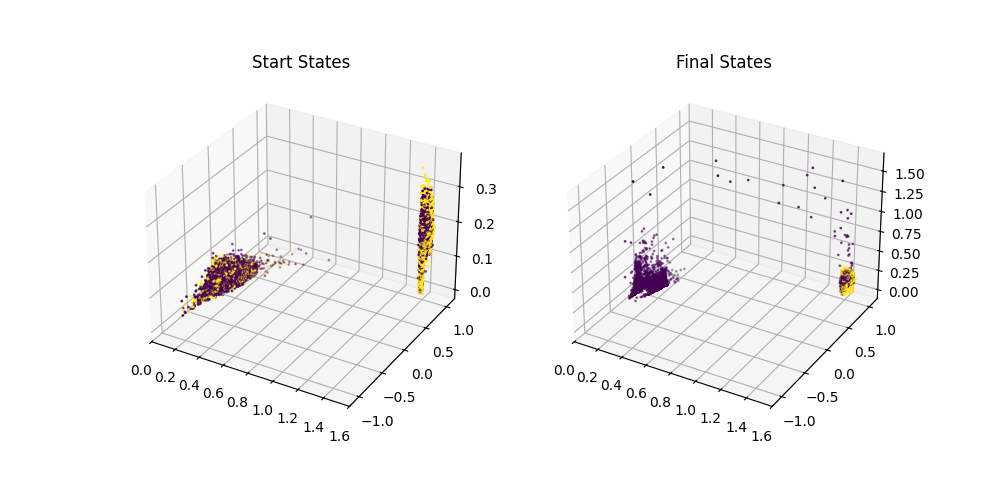

In [88]:


start_states = np.array(start_states)
final_states = np.array(final_states)
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})

ax[0].set_xlim(0, 1.6)
ax[0].set_ylim(-1.2, 1.2)
ax[0].set_title("Start States")

ax[1].set_xlim(0, 1.6)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title("Final States")

ax[0].scatter(
    start_states[:, 21],
    start_states[:, 36],
    np.sqrt(start_states[:, 37] ** 2 + start_states[:, 38] ** 2),
    c=split_labels,
    s=1
)
ax[1].scatter(
    final_states[:, 21],
    final_states[:, 36],
    np.sqrt(final_states[:, 37] ** 2 + final_states[:, 38] ** 2),
    c=split_labels,
    s=1
)

# Save the figure as a static image (PNG) and as an interactive HTML file
fig.savefig("start_final_3d.png", dpi=300, bbox_inches='tight')

# For interactive saving, use mpld3 or plotly
import mpld3
mpld3.save_html(fig, "start_final_3d_interactive.html")


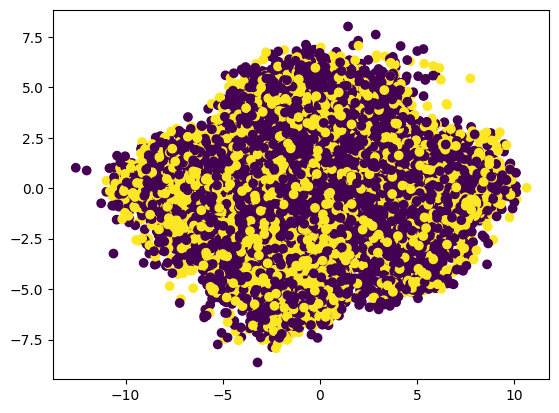

In [16]:
# sklearn pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# 3d pca
pca.fit(roa_data[:, :67])
pca_data = pca.transform(roa_data[:, :67])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pca_data[:, 0], pca_data[:, 1], c=labels.cpu().numpy())
plt.show()

In [21]:
# sklearn k-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3000)
kmeans.fit(roa_data[:, :67])


KMeans(n_clusters=3000)

In [19]:
kmeans.cluster_centers_

array([[-0.07780078, -0.20048736,  0.60616662, ...,  0.13336464,
         1.40956678,  0.75      ],
       [-0.68024338, -1.22933939, -0.61877218, ...,  0.87825075,
        -1.15997078,  0.5       ],
       [-0.36958073, -0.3014497 ,  0.61895227, ...,  0.36692403,
         1.72040195,  1.        ],
       ...,
       [-0.61946346, -1.25398391,  0.28815012, ...,  1.52191643,
         3.58551799,  1.        ],
       [ 0.16832232, -0.28175405, -0.054957  , ...,  0.62144619,
         3.30311976,  0.5       ],
       [-0.07724186, -0.60814977,  0.18425448, ...,  0.95020464,
         3.35262773,  1.        ]])

In [35]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Fit k-means with 3000 clusters
kmeans_3000 = KMeans(n_clusters=500, n_init="auto", random_state=0)
cluster_ids = kmeans_3000.fit_predict(roa_data)

# Ensure labels are 0/1 integers
labels = np.asarray(labels).astype(int)
if labels.shape[0] != cluster_ids.shape[0]:
    raise ValueError(f"Length mismatch: labels={labels.shape[0]} vs data/clusters={cluster_ids.shape[0]}")

# Compute counts of labels 0 and 1 within each cluster and the cluster size
ct = pd.crosstab(cluster_ids, labels)
if 0 not in ct.columns:
    ct[0] = 0
if 1 not in ct.columns:
    ct[1] = 0
ct = ct[[0, 1]]
ct.columns = ["count_label_0", "count_label_1"]
ct["cluster_size"] = ct["count_label_0"] + ct["count_label_1"]
ct.index.name = "cluster"
ct["failure_rate"] = ct["count_label_1"] / ct["cluster_size"]
ct["success_rate"] = ct["count_label_0"] / ct["cluster_size"]
cluster_stats = ct.reset_index().sort_values("cluster")


display(cluster_stats)
print(f"Total clusters: {cluster_stats.shape[0]}, total points: {int(cluster_stats['cluster_size'].sum())}")

# save as csv
cluster_stats.to_csv("cluster_stats.csv", index=False)

,cluster,count_label_0,count_label_1,cluster_size,failure_rate,success_rate
0,0,15,17,32,0.531250,0.468750
1,1,17,2,19,0.105263,0.894737
2,2,47,18,65,0.276923,0.723077
3,3,25,20,45,0.444444,0.555556
4,4,13,7,20,0.350000,0.650000
...,...,...,...,...,...,...
495,495,17,16,33,0.484848,0.515152
496,496,12,3,15,0.200000,0.800000
497,497,11,8,19,0.421053,0.578947
498,498,16,8,24,0.333333,0.666667


Total clusters: 500, total points: 15000
